# Project : Airbnb New User Booking
---

### 1. Introduction :

- purpose of analysis : Predict destination country

- evaluation metric : NDCG (Normalized discounted cumulative gain)


$$
DCG_k=\sum_{i=1}^k\frac{2^{rel_i}-1}{\log_2{\left(i+1\right)}}
$$

$$
nDCG_k=\frac{DCG_k}{IDCG_k}
$$


#### (1) Kaggle Result

- **171 / 1412 (상위 12.1%)**

![alt text](img/score.png)

---

![alt text](img/rating.png)

#### (2) Model Architecture
![alt text](img/model_architecture.jpg)

### 2. Methods

#### (1) Description of selected model : Light GBM

![alt text](img/lgb_parameter.jpg)

#### (2) feature engineering

##### (2)-1. train / test missing data  
- date_first_booking : drop
- age : filled using the lightGBM
- gender : filled uisng the lightGBM
- first_affiliate_tracked : filled by mode data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
df_train = pd.read_csv("train_users_2.csv")
df_test = pd.read_csv("test_users.csv")
df_all = pd.concat([df_train, df_test])
df_session = pd.read_csv('sessions.csv')

In [3]:
df_train_tmp = pd.DataFrame()
df_train_tmp["id"] = df_train.id
df_train_tmp["count"] = 1
df_train_tmp["NDF_DF"] = df_train["country_destination"].apply(lambda x : "NDF" if x == "NDF" else "DF")
df_train_tmp["country"] = df_train["country_destination"]

##### Missing Value

Missing data ratio
date_frist_booking : 67.73
age : 42.41
first_affiliate_tracked: 2.21


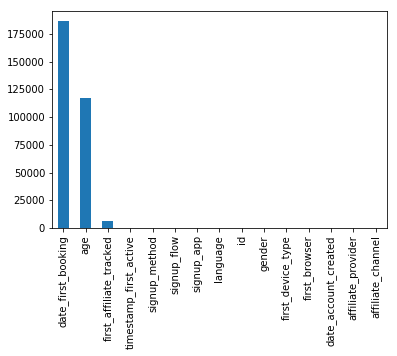

In [4]:
df_all = df_all.drop("country_destination", axis = 1)
df_all.isnull().sum().sort_values(ascending = False).plot(kind="bar")
print('Missing data ratio')
print('date_frist_booking :',round(df_all.date_first_booking.isnull().sum() / len(df_all) * 100, 2))
print('age :',round(df_all.age.isnull().sum() / len(df_all) * 100, 2))
print('first_affiliate_tracked:',round(df_all.first_affiliate_tracked.isnull().sum() / len(df_all) * 100, 2))

##### **Gender**

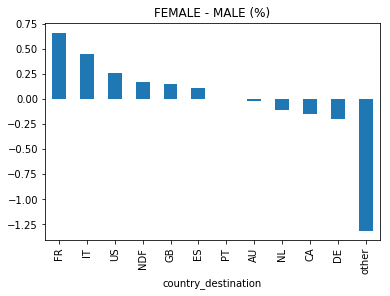

In [5]:
df_train["count"] = 1
df_gender_country = df_train.pivot_table(values = "count", index = ["country_destination"], columns = ["gender"], aggfunc=np.sum)
df_gender_country["FEMALE"] = df_gender_country["FEMALE"] / df_gender_country["FEMALE"].sum() * 100
df_gender_country["MALE"] = df_gender_country["MALE"] / df_gender_country["MALE"].sum() * 100
(df_gender_country["FEMALE"] - df_gender_country["MALE"]).sort_values(ascending = False).plot(kind="bar")
plt.title("FEMALE - MALE (%)")
plt.show()

- 여자는 FR, IT 로 여행갈 확률이 높다. 
- 남자는 other 로 여행갈 확률이 높다.

- **Missing value 처리 방법** : lightGBM을 이용해 gender 예측

##### **age**

In [6]:
labels = ["0-15", "15-25", "25-35", "35-60", "60-"]
bins = [0, 15, 25, 35, 60, 9999]

df_train["age_cut"] = pd.cut(df_train[df_train["age"] <= 120]['age'], 5, labels = labels)
df_age_pivot = df_train.pivot_table(values = "count", index = "age_cut", columns = "country_destination", aggfunc = np.sum, fill_value = 0)
for c in df_age_pivot.index:
    df_age_pivot.loc[c] = (df_age_pivot.loc[c] / (df_train["age_cut"] == c).sum() * 100)

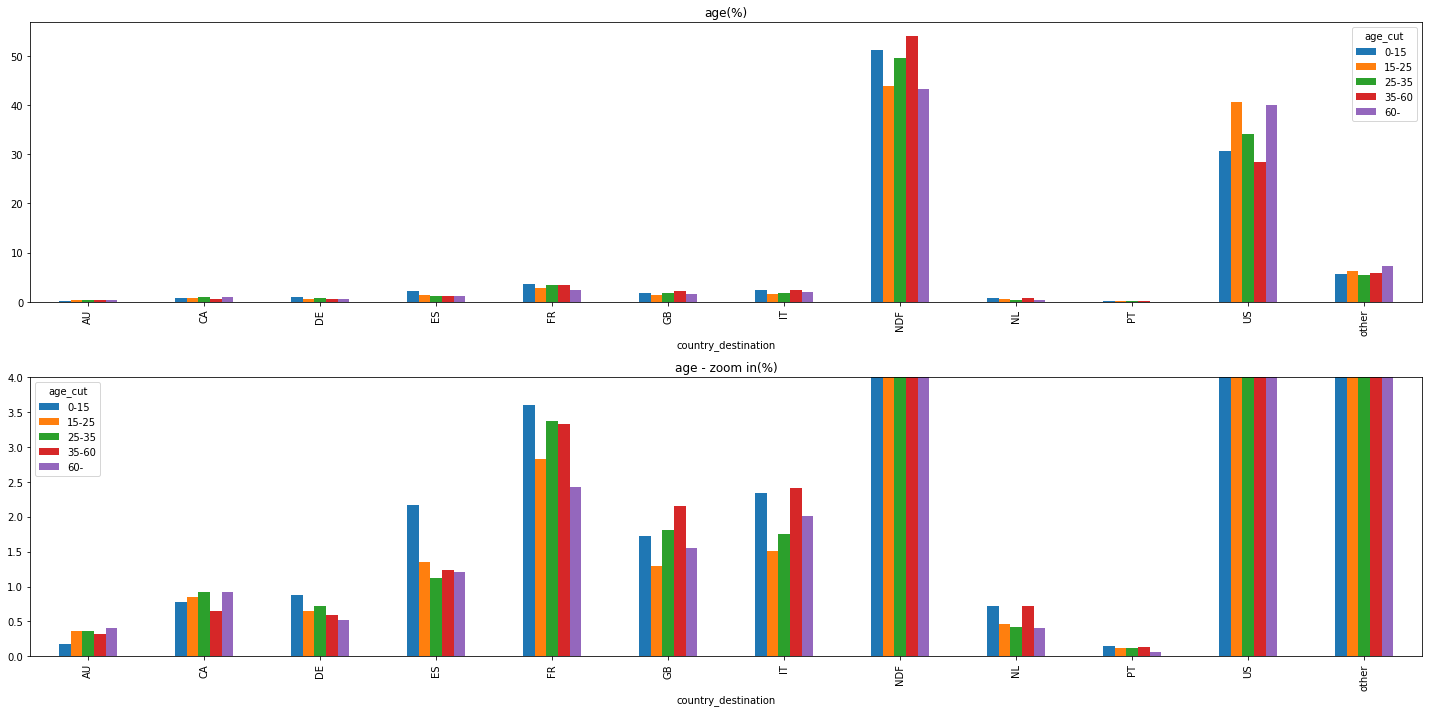

In [7]:
fig, axes = plt.subplots(2, 1, figsize = (20, 10))
df_age_pivot.T.plot(kind = "bar", ax = axes[0])
df_age_pivot.T.plot(kind = "bar", ax = axes[1])
axes[0].set_title("age(%)")
axes[1].set_title("age - zoom in(%)")
axes[1].set_ylim([0, 4])
plt.tight_layout()
plt.show()

- 연령대별로 다른 나라를 선택할 수 있다.

- **Missing value 처리 방법** : lightGBM을 이용해 age 예측

##### **first_affiliate_tracked**

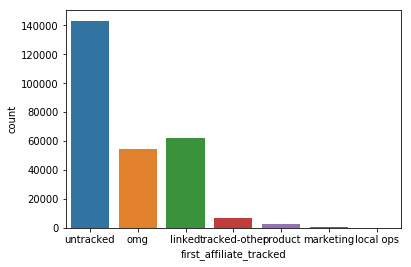

untracked        51.962460
linked           22.523925
omg              19.909126
tracked-other     2.415196
product           0.853938
marketing         0.101979
local ops         0.025041
Name: first_affiliate_tracked, dtype: float64


In [8]:
sns.countplot(df_all["first_affiliate_tracked"])
plt.show()
print(df_all["first_affiliate_tracked"].value_counts() / len(df_all) * 100)

- 전체 특징에서 51.96%가 untracked

- **Missing value 처리 방법** : 최빈값 `untracked` 으로 Missing value 처리

##### **date_first_booking**

In [9]:
test_exist = len(df_test) - df_test["date_first_booking"].isnull().sum()
print("Number of date_first_booking in test : {}".format(test_exist))

Number of date_first_booking in test : 0


- test 데이터에는 date_first_booking 특징이 전혀 존재하지 않는다. 

- **Missing value 처리 방법** :해당 특징은 사용하지 않는다.

##### (3)-2. sessions 
- **가정) session 정보가 많을수록 컴퓨터를 많이 이용해 나라를 예약할 확률이 높다.**
- action, action type, action detial : count, mode 
- secs elapsed : mode, mean, median
- device types : mode

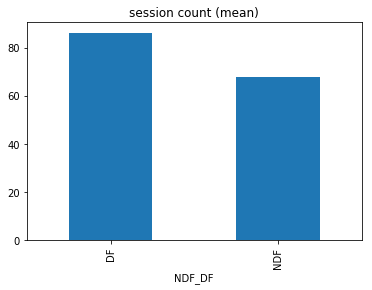

In [10]:
df_log_count = pd.DataFrame(df_session.groupby(["user_id"])["user_id"].count().fillna(0)).rename(columns = {"user_id":"log_count"})
df_train_count = df_train_tmp.merge(df_log_count, how = 'inner', left_on = "id", right_index = True)
df_train_count_mean  = df_train_count.groupby(["NDF_DF"])["log_count"].mean()
df_train_count_mean.plot(kind="bar")
plt.title("session count (mean)")
plt.show()

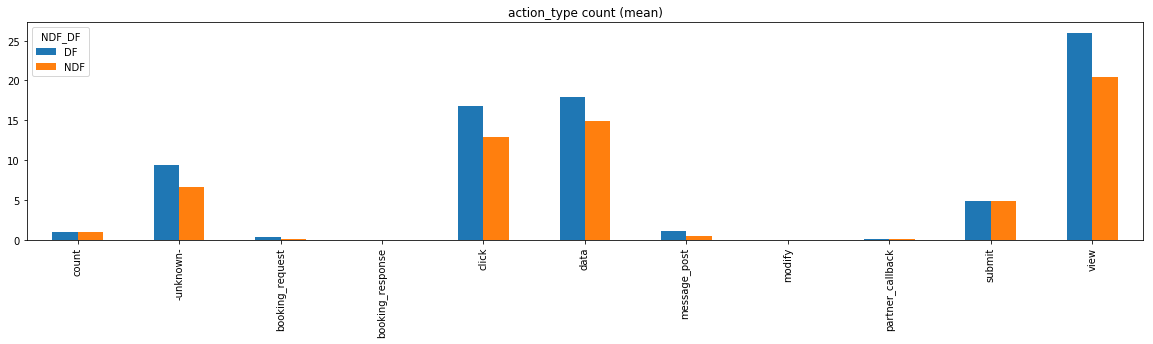

In [11]:
df_type_count = pd.DataFrame(df_session.groupby(["user_id", "action_type"])["user_id"].count().unstack().fillna(0))
df_train_type = df_train_tmp.merge(df_type_count, how = 'inner', left_on = "id", right_index = True)
df_train_type_mean  = df_train_type.groupby(["NDF_DF"]).mean()
df_train_type_mean.T.plot(kind = "bar", figsize=(20, 4))
plt.title("action_type count (mean)")
plt.show()

- action_type count값의 mean를 보았을 때,  session값이 많을 수록, 특히 (click, data, view) count의 값이 커질 수록 DF일 확률이 높다.

##### (3)-3. first-active, create-account
- **가정 1) weekend, holyday일 때 활동할수록 나라를 예약할 확률이 높다.**
- first-active : weekend, holydays, year, month, day
- create-account : year, month, day
- lag : create-account - first-active

In [12]:
df_train_last = pd.read_csv("last_train.csv")

In [13]:
li_target = df_train_last["country_destination"].unique()
li_wk = ["mon", "tue", "wed", "thur", "fri", "sat", "sun"]

In [14]:
df_wk = pd.DataFrame(index = li_wk, columns = li_target)

for d in li_wk:
    df_wk.loc[d] = df_train_last[df_train_last[d] == 1].groupby(["country_destination"])["country_destination"].count() / len(df_train_last[df_train_last[d] == 1]) * 100

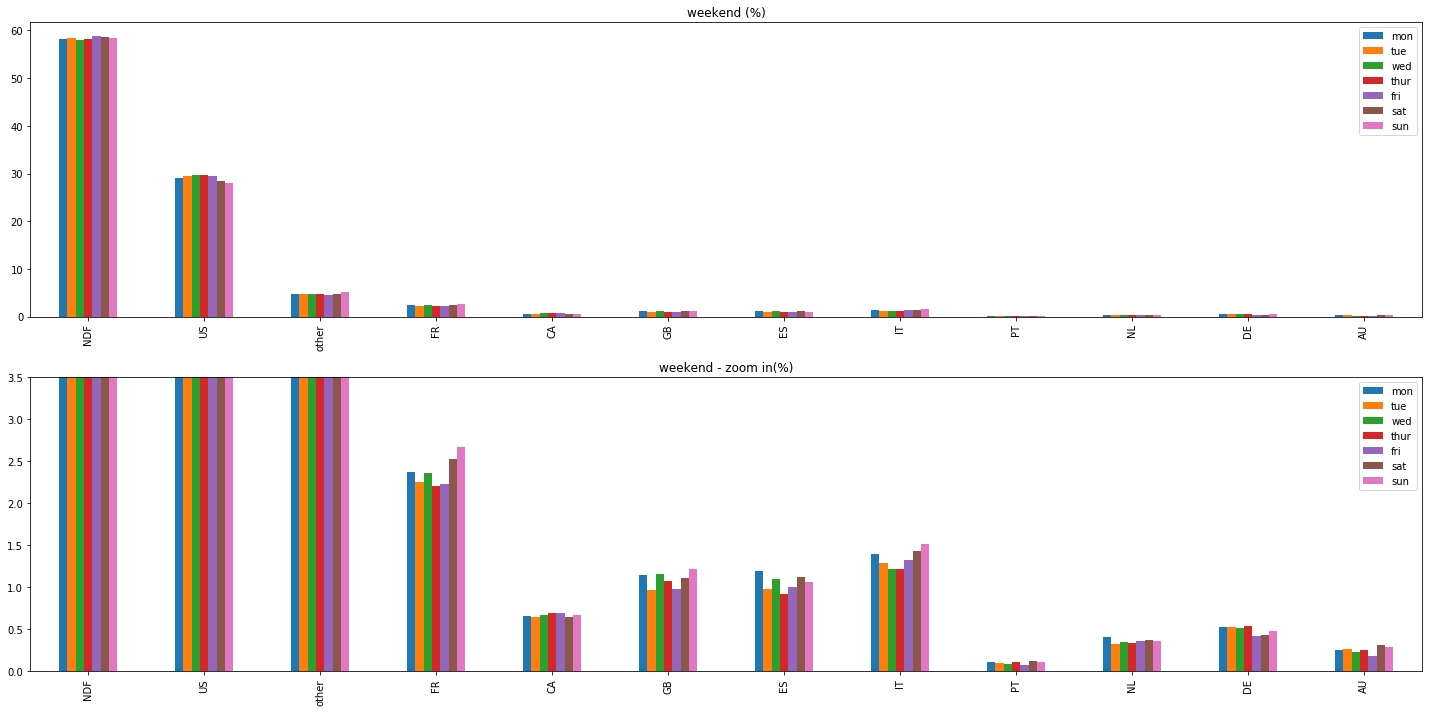

In [15]:
fig, axes = plt.subplots(2, 1, figsize = (20, 10))
df_wk.T.plot(kind = "bar", ax = axes[0])
df_wk.T.plot(kind = "bar", ax = axes[1])
axes[0].set_title("weekend (%)")
axes[1].set_title("weekend - zoom in(%)")
axes[1].set_ylim([0, 3.5])
plt.tight_layout()
plt.show()

##### (3)-4. faithless-sign
- **가정) gender와 age를 unknown이라고 입력할수록 NDF일 활률이 높다**

In [16]:
df_train_tmp["age_known"] = df_train['age'] < 120
df_train_tmp["gender_known"] = df_train['gender'] != '-unknown-'

In [17]:
df_age_NDF_DF = df_train_tmp.pivot_table(values = "count", columns = "age_known", index = "NDF_DF", aggfunc="sum")
for idx in df_age_NDF_DF.index:
    df_age_NDF_DF.loc[idx] = df_age_NDF_DF.loc[idx] / np.sum(df_age_NDF_DF.loc[idx]) * 100
    
df_gender_NDF_DF = df_train_tmp.pivot_table(values = "count", columns = "gender_known", index = "NDF_DF", aggfunc="sum")
for idx in df_gender_NDF_DF.index:
    df_gender_NDF_DF.loc[idx] = df_gender_NDF_DF.loc[idx] / np.sum(df_gender_NDF_DF.loc[idx]) * 100 

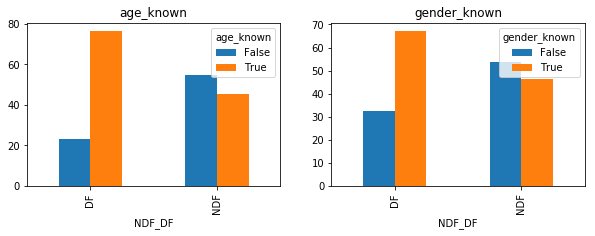

In [18]:
fig, ax =plt.subplots(1, 2, figsize = (10, 3))
df_age_NDF_DF.plot(kind = "bar", ax = ax[0])
ax[0].set_title("age_known")
df_gender_NDF_DF.plot(kind = "bar", ax = ax[1])
ax[1].set_title("gender_known")
plt.show()

- sign을 할 때 age, gender를 입력했을 때, 여행을 갈 확률이 높다고 판단.
- 그러므로 age와 gender 둘중 하나가 unknown일 때 faithless-sign 이라 한다.

##### (3)-5. drop age-bks, countries
- dropped data : age bkts, countries

#### (4) Feature Selection

- Feature Importance > 3 이상의 특징만 선별 
- Feature Number : 1051 -> 456

#### (5) Parameter Tuning

![alt text](img/try-error_1.png)`

### 4. Result

#### (1) Classification Report

![alt text](img/classification report.png )

#### (2) Accuracy Score

![alt text](img/accuracy.png)

#### (3) Feature importance

![alt text](img/feature importance.png) 

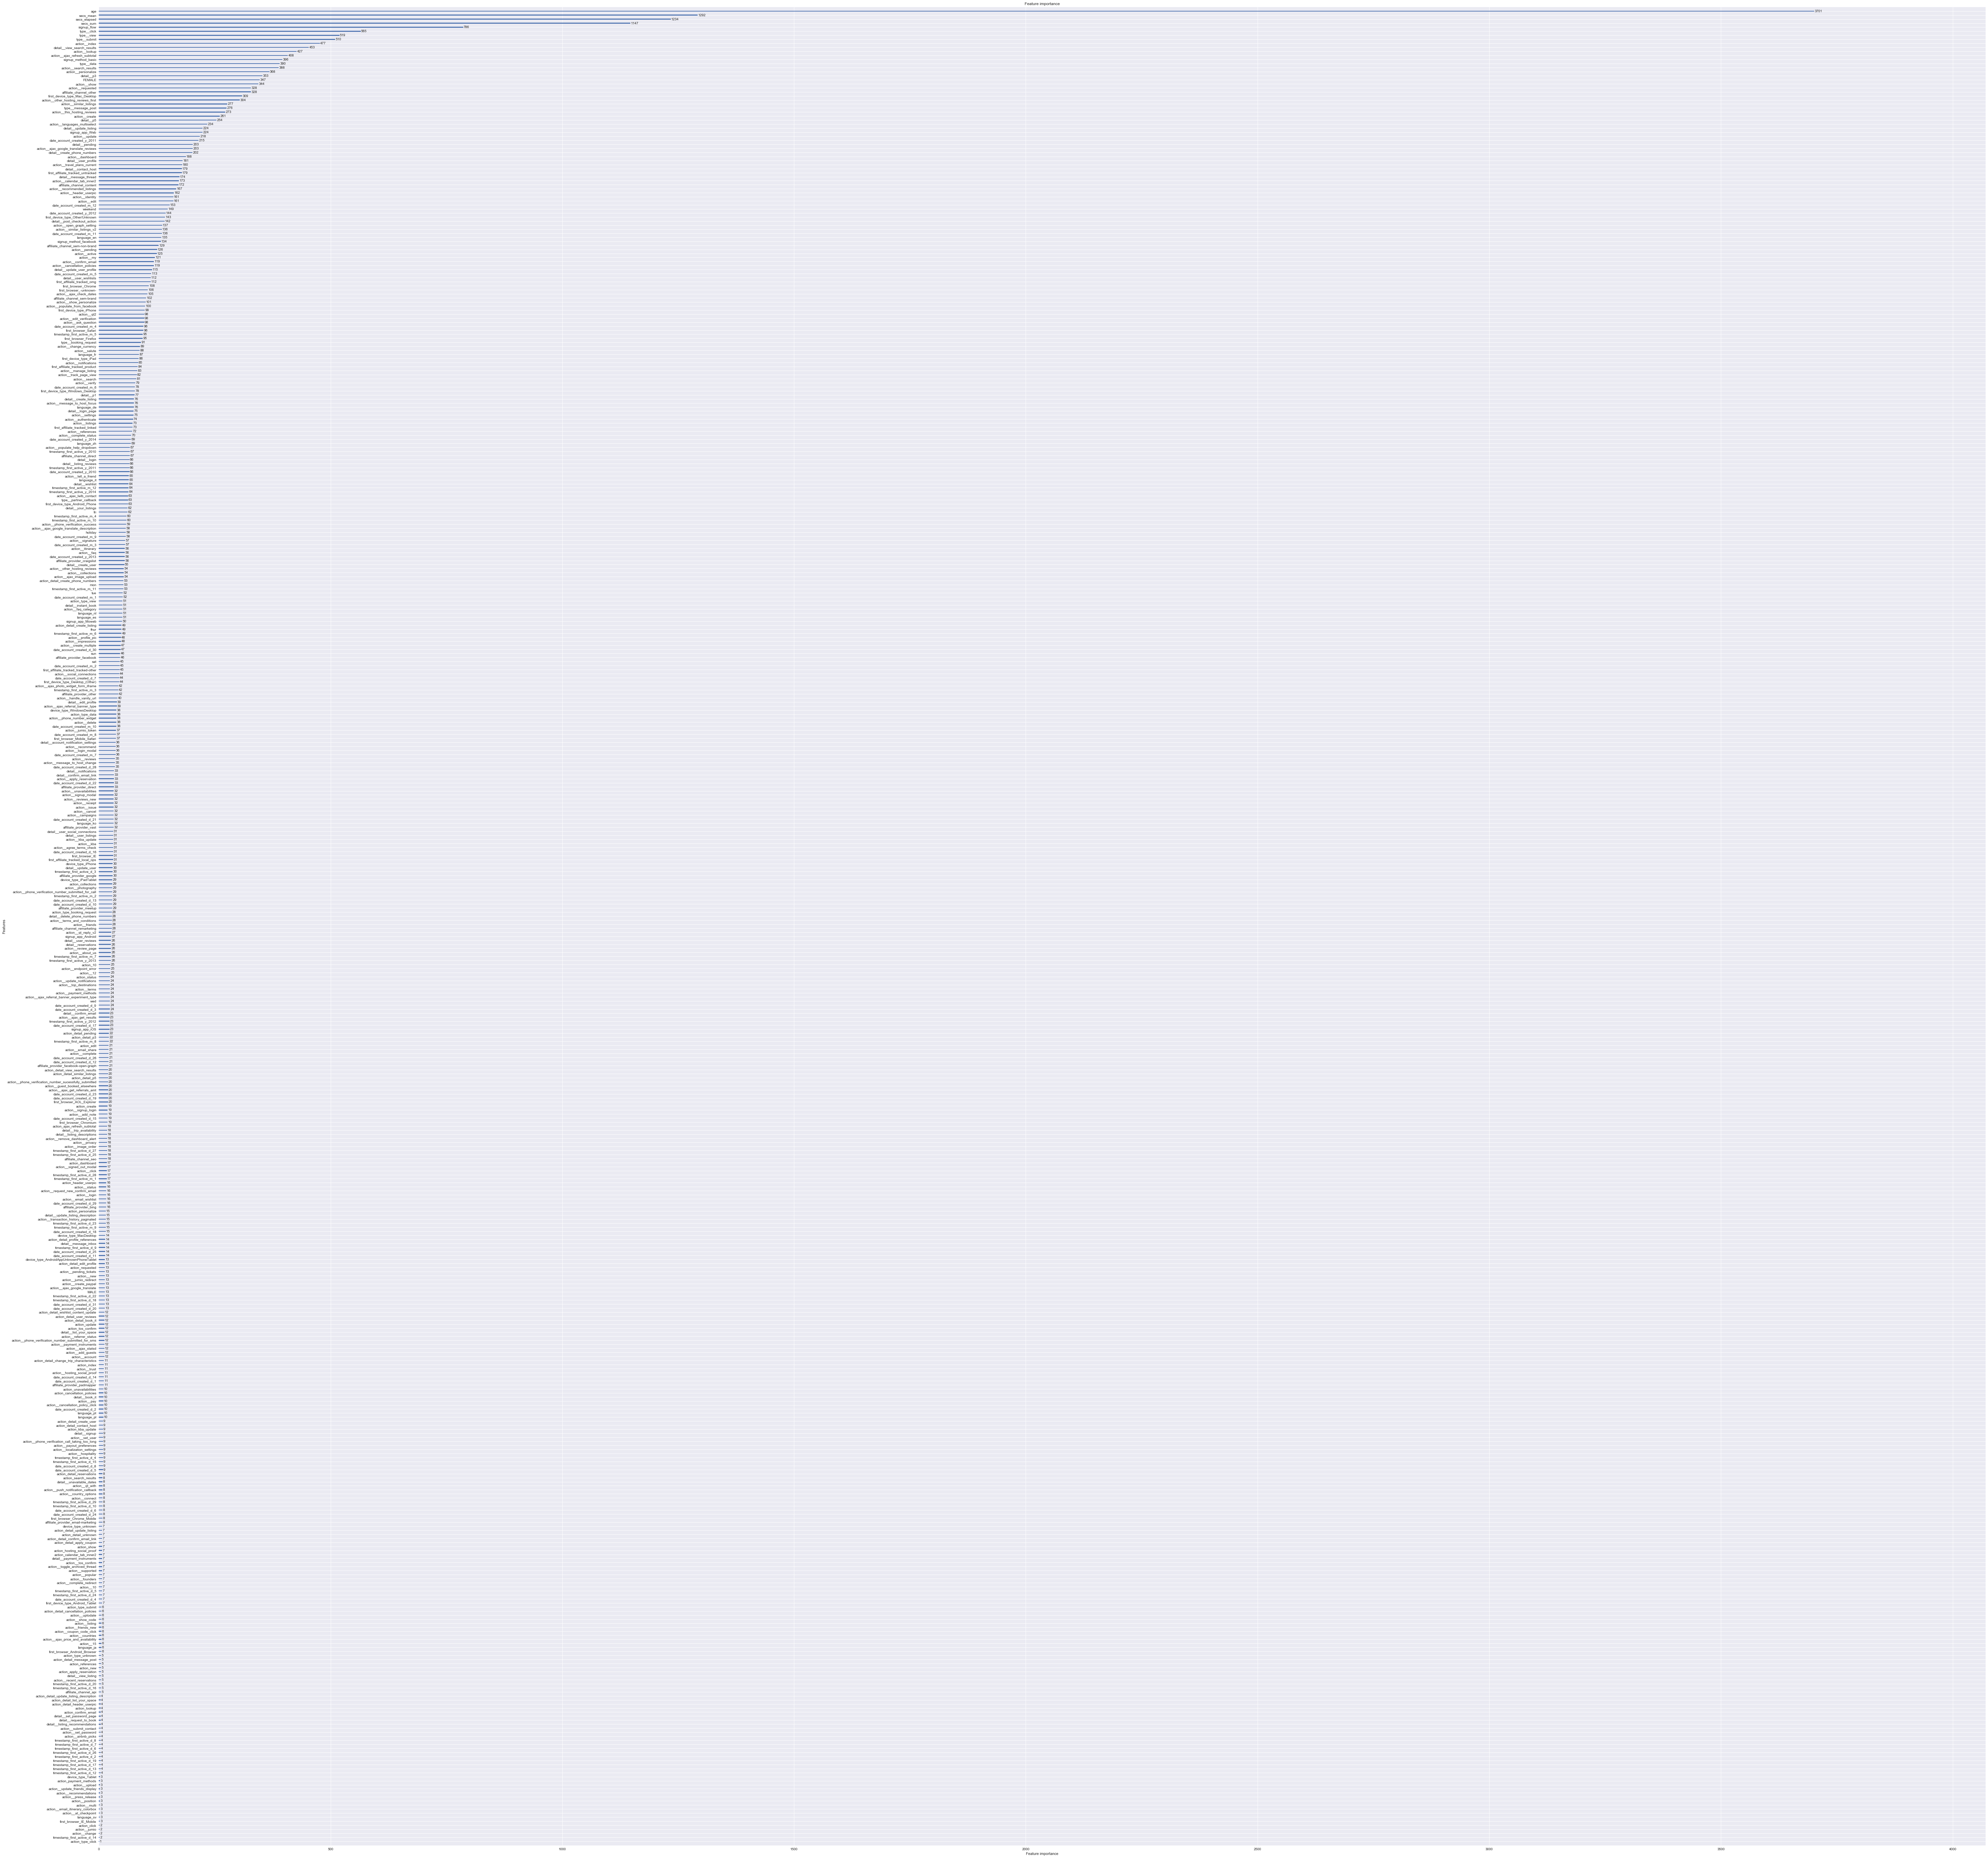

In [14]:
plot_importance(model_lgb_i, figsize=(100, 100))

### 5. Conclusion

#### (1) feature importance 상위 15개 정보 분석

- **age**
- **lag_seconds**
- **signup_flow** 
- **faithless_sign**
- **session : elapsed secs(mean, sum, median)**
- **count(type_view, type_click, type_data, type_submit)** 
- **count(action_index, action_view_search_results, action_lookup, action_ajax_refresh_subtotal)**

#### (2) 가정에 대한 분석

- **가정 1) session 정보가 많을수록 컴퓨터를 많이 이용해 나라를 예약할 확률이 높다.**
  - feature importance에서도 EDA처럼 type_view, type_click, type_data의 count가 영향이 컸고 거기에 type_submit도 큰 영향을 미쳤다.


- **가정 2) weekend, holyday일 때 활동할수록 나라를 예약할 확률이 높다.**
  - feature importance에서 weekend(146, 49등)이다. 그러므로 예측을 하는 데 영향을 미친다고 할 수 있다.
  - feature importance에서 holyday(57, 138등)이다. 평균보다 낮음으로 예측하는 데는 큰 영향을 미친다고 할 수 있다. 


- **가정 3) gender와 age를 unknown이라고 입력할수록 NDF일 활률이 높다**
  - feature importance에서도 faithless_sign(667, 7등)이다. 그러므로 가정이 맞았다고 할 수 있다.


** importance mean : 76, median : 28

---

### code implementation

In [19]:
from airpy.agd import * # age+gender predict data

check, pre_age = pre_age_set_data(train_users_2, test_users)
pre_gen_mission_test, pre_gen_train_test, pre_gen_mission, pre_gen_train, \
            pre_gen_mission_test_drop, pre_gen_train_test_drop = pre_gen_predict_data(pre_age)

model_gen_lgb = predict_gen_LightGBM(pre_gen_train_test_drop, pre_gen_train_test, pre_gen_train_test_drop)
model_gen_lgb.to_csv("model_gen_lgb.csv", index=False)
pre_age_mission_test, pre_age_train_test, pre_age_mission, pre_age_train, \
            pre_age_mission_test_drop, pre_age_train_test_drop = pre_age_predict_data(pre_age)

cats = pre_age_predict_data_cat(pre_age_train)
model_age_lgb = predict_age_LightGBM(pre_age_train_test_drop, cats, pre_age_mission_test_drop)
model_age_lgb.to_csv("model_age_lgb.csv", index=False)

             precision    recall  f1-score   support

     FEMALE       0.58      0.72      0.65     77524
       MALE       0.57      0.42      0.48     68209

avg / total       0.58      0.58      0.57    145733

             precision    recall  f1-score   support

         노년       0.67      0.00      0.01      9993
       미성년자       0.90      0.65      0.75        68
         장년       0.48      0.38      0.43     55518
         중년       0.50      0.79      0.61     70900
         청년       0.55      0.04      0.08     22202

avg / total       0.51      0.49      0.43    158681



In [20]:
from airpy.merge import * # sessions merged data

merged_sessions = make_merged_sessions()
merged_sessions = remove_word()
merged_sessions = sessions_detail_add()

In [21]:
from airpy.data import * # classification data

check, pre_age = pre_age_set_data(train_users_2, test_users)

pre_age_mission_test, pre_age_train_test, pre_age_mission, pre_age_train, \
            pre_age_mission_test_drop, pre_age_train_test_drop = pre_age_predict_data(pre_age)

cats = pre_age_predict_data_cat(pre_age_train)
last_gen_add = add_gender(pre_age)
add_hol = holiday(train_users_2, test_users)
last_train_data, last_test_data, y_label, le = predict_age_add(pre_age_mission_test, pre_age_train_test, last_gen_add, add_hol)
last_train_data_add, last_test_data_add = last_data_setting(last_train_data, last_test_data)

In [22]:
def pre_setting():
    last_train_data_add = pd.read_csv("last_train.csv")
    last_test_data_add = pd.read_csv("last_test.csv")
    
    X = last_train_data_add
    y = last_test_data_add
    
#     clf1 = linear_model.LogisticRegression(n_jobs=-1)
#     clf2 = RandomForestClassifier(n_jobs=-1)
#     clf3 = ExtraTreesClassifier(n_jobs=-1)
#     clf4 = xgb.XGBClassifier(nthread=3, n_jobs=-1)
    clf5 = lgb.LGBMClassifier(nthread=3, n_jobs=-1, reg_alpha=1)
#     eclf2 = VotingClassifier(estimators=[('log', clf1), ('rf', clf2), ('ex', clf3), ('xgb', clf4), ('lgb', clf5)], voting='soft', weights=[1,1,1,1,1])
    
    return X, y, clf5

In [23]:
X, y, clf5  = pre_setting()

In [24]:
def submit_kaggle(df_train, df_test, model, user_id, target):
    
    le = LabelEncoder()

    y_train = le.fit_transform(df_train[target])
    X_train = df_train.drop([target, user_id], axis = 1)
    
    X_test_id = df_test[user_id]
    X_test = df_test.drop([target, user_id], axis = 1)
    

    print("model fitting 시작")
    
    model = model.fit(X_train, y_train)
    
    predic_proba = model.predict_proba(X_test)
    
   
    print("model fitting 종료")

    df_submit = pd.DataFrame(columns=["id", "country"])
    ids = []
    cts = []
    for i in range(len(X_test_id)):
        idx = X_test_id.iloc[i]
        ids += [idx] * 5
        cts += le.inverse_transform(np.argsort(predic_proba[i])[::-1])[:5].tolist()
    df_submit["id"] = ids
    df_submit["country"] = cts
    df_submit.to_csv('submit_xg.csv', index = False)
    print("csv file 생성")
#     !kaggle competitions submit -c airbnb-recruiting-new-user-bookings -f 'submit_xg.csv' -m "Message"

In [25]:
submit_kaggle(X, y, clf5, "id", "country_destination")

model fitting 시작
model fitting 종료
csv file 생성
